In [2]:
#importing neccessary library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import folium
import warnings
warnings.filterwarnings('ignore')

In [3]:
#load dataset
temp_df = pd.read_csv('temperature.csv')
binsize_df=pd.read_csv('BinSize.csv')

In [4]:
temp_df.head()

,ID,Date,Element,Data_Value
0,USW00094889,2014-11-12,TMAX,22
1,USC00208972,2009-04-29,TMIN,56
2,USC00200032,2008-05-26,TMAX,278
3,USC00205563,2005-11-11,TMAX,139
4,USC00200230,2014-02-27,TMAX,-106


In [5]:
binsize_df.head()

,ID,LATITUDE,LONGITUDE,ELEVATION,STATE,NAME,GSNFLAG,HCNFLAG,WMOID,x,y,x_group,y_group,xy_group,hash
0,AE000041196,25.333,55.517,34.0,NaN,SHARJAH INTER. AIRP,GSN,NaN,41196.0,5.579578e+06,2.816905e+06,5497601.479782179 to 5594934.908498545,2772265.475723952 to 2869598.904440318,"5497601.479782179 to 5594934.908498545, 277226...",1f6f0e89f4e937d934fe9acde2545e0d66bbcfe3b66320...
1,AEM00041194,25.255,55.364,10.4,NaN,DUBAI INTL,NaN,NaN,41194.0,5.567782e+06,2.808232e+06,5497601.479782179 to 5594934.908498545,2772265.475723952 to 2869598.904440318,"5497601.479782179 to 5594934.908498545, 277226...",1f6f0e89f4e937d934fe9acde2545e0d66bbcfe3b66320...
2,AEM00041217,24.433,54.651,26.8,NaN,ABU DHABI INTL,NaN,NaN,41217.0,5.532707e+06,2.716829e+06,5497601.479782179 to 5594934.908498545,2674932.047007587 to 2772265.4757239525,"5497601.479782179 to 5594934.908498545, 267493...",35c9093084d26708afc5b482ea15ba52e3f20fb7cd781f...
3,AEM00041218,24.262,55.609,264.9,NaN,AL AIN INTL,NaN,NaN,41218.0,5.637301e+06,2.697815e+06,5594934.908498544 to 5692268.33721491,2674932.047007587 to 2772265.4757239525,"5594934.908498544 to 5692268.33721491, 2674932...",2a6a7edad90579049fd1b3c3a990e8a8be90cb1975118e...
4,AFM00040990,31.500,65.850,1010.0,NaN,KANDAHAR AIRPORT,NaN,NaN,40990.0,6.243199e+06,3.502645e+06,6178935.480796736 to 6276268.909513102,3453599.476738509 to 3550932.9054548745,"6178935.480796736 to 6276268.909513102, 345359...",039e75bbef55baa3fecc0568dc3b245666a98b1bcba6b4...


In [6]:
temp_df.isna().sum()

,0
ID,0
Date,0
Element,0
Data_Value,0


In [7]:
binsize_df.isna().sum()


,0
ID,0
LATITUDE,0
LONGITUDE,0
ELEVATION,0
STATE,5452
NAME,0
GSNFLAG,17332
HCNFLAG,16877
WMOID,12088
x,0


In [8]:
#handlig missing values in binsize
binsize_df.fillna({
    'STATE': 'Unknown',
    'GSNFLAG': 'No Data',
    'HCNFLAG': 'No Data',
    'WMOID': 'No Data'
}, inplace=True)

In [9]:
# Convert date column to datetime format
temp_df["Date"] = pd.to_datetime(temp_df["Date"])


In [10]:
# Remove leap year days (Feb 29th)
temp_df = temp_df[~((temp_df["Date"].dt.month == 2) & (temp_df["Date"].dt.day == 29))]


In [11]:
# Extract year and day-of-year for grouping
temp_df['year'] = temp_df["Date"].dt.year
temp_df['day_of_year'] = temp_df["Date"].dt.strftime('%m-%d')

In [12]:
# Split into historical (2005-2014) and 2015 datasets
historical_df = temp_df[(temp_df['year'] >= 2005) & (temp_df['year'] <= 2014)]
data_2015 = temp_df[temp_df['year'] == 2015]

In [13]:
# Compute record highs and lows for each day-of-year
daily_max = historical_df.groupby('day_of_year')['Data_Value'].max()
daily_min = historical_df.groupby('day_of_year')['Data_Value'].min()

In [14]:

# Find where 2015 broke records
broken_highs = data_2015[data_2015['Data_Value'] > data_2015['day_of_year'].map(daily_max)]
broken_lows = data_2015[data_2015['Data_Value'] < data_2015['day_of_year'].map(daily_min)]

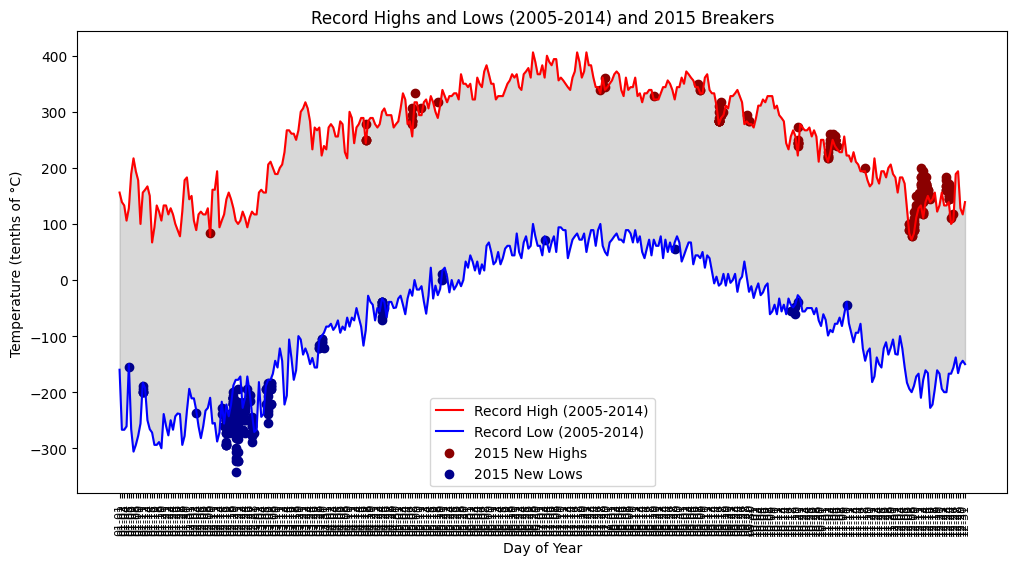

In [15]:
# Plot high and low temperatures
plt.figure(figsize=(12, 6))
plt.plot(daily_max.index, daily_max.values, label='Record High (2005-2014)', color='red')
plt.plot(daily_min.index, daily_min.values, label='Record Low (2005-2014)', color='blue')
plt.fill_between(daily_max.index, daily_min.values, daily_max.values, color='gray', alpha=0.3)
plt.scatter(broken_highs['day_of_year'], broken_highs['Data_Value'], color='darkred', label='2015 New Highs')
plt.scatter(broken_lows['day_of_year'], broken_lows['Data_Value'], color='darkblue', label='2015 New Lows')
plt.xticks(rotation=90, fontsize=8)
plt.xlabel('Day of Year')
plt.ylabel('Temperature (tenths of °C)')
plt.title('Record Highs and Lows (2005-2014) and 2015 Breakers')
plt.legend()
plt.show()

In [16]:
# Map station locations (assuming binsize_df contains latitude & longitude)
station_map = folium.Map(location=[42.2808, -83.7430], zoom_start=10)
for _, row in binsize_df.iterrows():
    folium.Marker(location=[row['LATITUDE'], row['LONGITUDE']], popup=row['ID']).add_to(station_map)
station_map.save("station_map.html")  # Save map to file

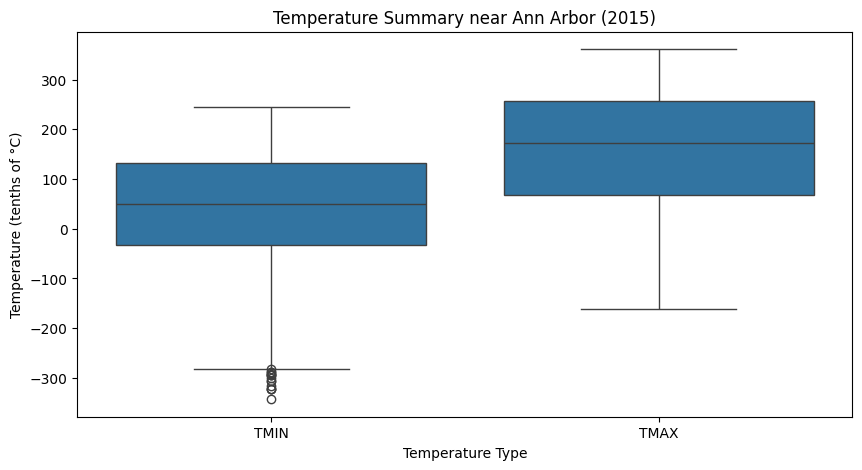

In [17]:
# Summary of temperature trends in 2015
plt.figure(figsize=(10, 5))
sns.boxplot(x='Element', y='Data_Value', data=data_2015)
plt.xlabel("Temperature Type")
plt.ylabel("Temperature (tenths of °C)")
plt.title("Temperature Summary near Ann Arbor (2015)")
plt.show()